In [339]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [340]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [341]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354046 entries, 0 to 2354045
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 35.9 MB


# reduce to 1 million events

In [342]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion millisec -> sec

In [343]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,24400,0.15,24.400
1,24252,0.15,24.252
2,24406,0.15,24.406
3,24268,0.15,24.268
4,24482,0.15,24.482
...,...,...,...
999995,30909,0.12,30.909
999996,30532,0.12,30.532
999997,29231,0.12,29.231
999998,29478,0.12,29.478


### conversion Interval -> kWh

In [344]:
conso_data['Wh']=3600000/conso_data['Interval']
conso_data


,Interval,kWh,sec,Wh
0,24400,0.15,24.400,147.540984
1,24252,0.15,24.252,148.441366
2,24406,0.15,24.406,147.504712
3,24268,0.15,24.268,148.343498
4,24482,0.15,24.482,147.046810
...,...,...,...,...
999995,30909,0.12,30.909,116.470931
999996,30532,0.12,30.532,117.909079
999997,29231,0.12,29.231,123.156922
999998,29478,0.12,29.478,122.124975


### Cumul Total interval

In [345]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [346]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

26906277518000

### Calcul de la date de base = now - cumul_interval

In [347]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 8, 24, 23, 24, 34, 930484)

In [348]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [349]:
conso_data.iloc[0]


Interval     24400.000000
kWh              0.150000
sec             24.400000
Wh             147.540984
cumul(ms)    24400.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [350]:
base

datetime.datetime(2024, 8, 24, 23, 24, 34, 930484)

## créer les dates

In [351]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-08-24 23:24:59.330484
1        2024-08-24 23:25:23.582484
2        2024-08-24 23:25:47.988484
3        2024-08-24 23:26:12.256484
4        2024-08-24 23:26:36.738484
                    ...            
999995   2025-07-02 09:20:33.576484
999996   2025-07-02 09:21:04.108484
999997   2025-07-02 09:21:33.339484
999998   2025-07-02 09:22:02.817484
999999   2025-07-02 09:22:32.448484
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [352]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,24400,0.15,24.400,147.540984,24400,2024-08-24 23:24:59.330484,24/08/24
1,24252,0.15,24.252,148.441366,48652,2024-08-24 23:25:23.582484,24/08/24
2,24406,0.15,24.406,147.504712,73058,2024-08-24 23:25:47.988484,24/08/24
3,24268,0.15,24.268,148.343498,97326,2024-08-24 23:26:12.256484,24/08/24
4,24482,0.15,24.482,147.046810,121808,2024-08-24 23:26:36.738484,24/08/24
...,...,...,...,...,...,...,...
999995,30909,0.12,30.909,116.470931,26906158646,2025-07-02 09:20:33.576484,02/07/25
999996,30532,0.12,30.532,117.909079,26906189178,2025-07-02 09:21:04.108484,02/07/25
999997,29231,0.12,29.231,123.156922,26906218409,2025-07-02 09:21:33.339484,02/07/25
999998,29478,0.12,29.478,122.124975,26906247887,2025-07-02 09:22:02.817484,02/07/25


### save conso_data with dates

In [353]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [354]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('02/07/25', 2, 7, 2025, '09:22:48')

In [355]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [356]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1093 entries, 998907 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1093 non-null   int64         
 1   kWh        1093 non-null   float64       
 2   sec        1093 non-null   float64       
 3   Wh         1093 non-null   float64       
 4   cumul(ms)  1093 non-null   int64         
 5   dates      1093 non-null   datetime64[ns]
 6   days       1093 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 68.3+ KB


In [357]:
end = time.time()
print(end - start)

21.779431581497192


### grouped by days

In [358]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [359]:
data = list(df_grp['kWh'])
print(data)

[0.097, 4.047, 3.833, 3.953, 3.746, 4.04, 3.605, 3.701, 3.535, 3.638, 3.509, 4.151, 3.525, 3.653, 3.584, 3.154, 2.603, 1.799, 1.792, 1.795, 1.794, 2.429, 1.909, 1.787, 1.793, 1.788, 1.82, 1.82, 1.817, 1.815, 1.817, 1.818, 1.815, 1.817, 1.784, 1.788, 1.784, 1.785, 1.783, 1.798, 1.788, 1.79, 1.785, 1.794, 1.802, 1.796, 1.801, 1.798, 1.786, 1.788, 1.786, 1.791, 1.796, 1.791, 1.8, 1.804, 1.793, 1.801, 1.799, 2.67, 4.0, 3.677, 3.901, 3.097, 3.398, 4.093, 3.398, 3.444, 4.01, 3.335, 3.715, 3.575, 3.982, 3.203, 3.318, 3.419, 4.072, 3.28, 3.381, 3.823, 3.226, 3.554, 3.3, 3.902, 3.351, 3.432, 3.731, 4.422, 3.601, 3.873, 3.398, 4.171, 3.507, 3.434, 3.311, 3.851, 3.681, 4.12, 3.21, 3.743, 3.785, 3.174, 3.678, 3.666, 3.37, 3.881, 3.189, 4.081, 3.423, 3.744, 4.042, 3.413, 4.528, 3.252, 3.483, 3.094, 3.223, 3.435, 3.352, 3.395, 3.463, 4.637, 4.505, 3.235, 3.439, 3.652, 3.962, 3.512, 4.452, 4.176, 4.126, 3.735, 3.777, 3.516, 3.543, 4.38, 3.171, 3.374, 3.393, 3.451, 3.609, 3.386, 4.556, 3.262, 3.787, 3

In [360]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [361]:
end = time.time()
print(end - start)

22.666922330856323


### plot function by day
#### show('dd/mm/yy')

In [362]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


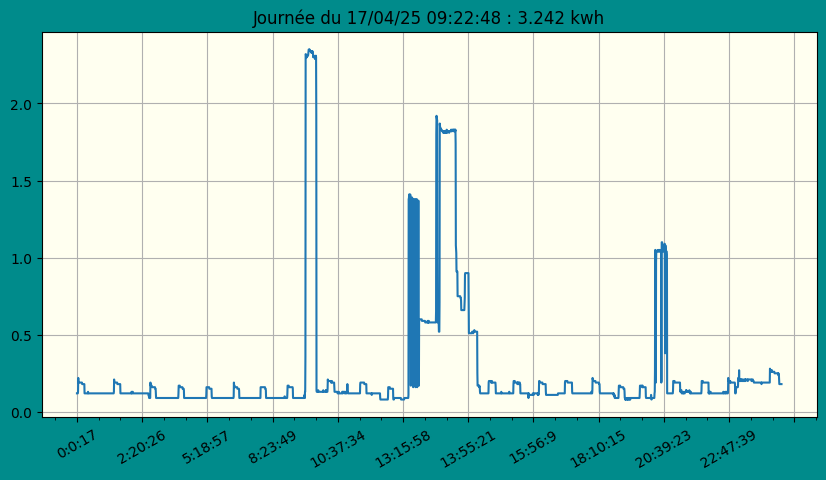

In [363]:
show('17/04/25')

In [364]:
end = time.time()
print(end - start)

23.73404288291931


### 1 kWh window in data of one day
#### df = conso_day

In [365]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998907,30748,0.12,30.748,117.080786,26872554580,2025-07-02 00:00:29.510484,02/07/25
998908,30795,0.12,30.795,116.902094,26872585375,2025-07-02 00:01:00.305484,02/07/25
998909,24648,0.15,24.648,146.056475,26872610023,2025-07-02 00:01:24.953484,02/07/25
998910,18153,0.20,18.153,198.314328,26872628176,2025-07-02 00:01:43.106484,02/07/25
998911,17106,0.21,17.106,210.452473,26872645282,2025-07-02 00:02:00.212484,02/07/25
...,...,...,...,...,...,...,...
999995,30909,0.12,30.909,116.470931,26906158646,2025-07-02 09:20:33.576484,02/07/25
999996,30532,0.12,30.532,117.909079,26906189178,2025-07-02 09:21:04.108484,02/07/25
999997,29231,0.12,29.231,123.156922,26906218409,2025-07-02 09:21:33.339484,02/07/25
999998,29478,0.12,29.478,122.124975,26906247887,2025-07-02 09:22:02.817484,02/07/25


In [366]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [367]:
df = conso_day
len(df)

1093

In [368]:
period()  # first kWh
if len(df)>1000:
    period(p=2) # second period

2025-07-02 00:00:29.510484	2025-07-02 08:43:24.105484	8h 42m 54s 	1000
2025-07-02 08:43:24.105484	2025-07-02 09:22:32.448484	0h 39m 8s 	93


In [369]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.298869
dtype: float64

In [370]:
end = time.time()
print(end - start)

23.983048915863037


## mean for data grouped by days

In [371]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.194888
dtype: float64

In [372]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(1.093)

# conso by date


In [373]:
# select day
day = today

#day = '16/08/24'
day

'02/07/25'

In [374]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998907,30748,0.12,30.748,117.080786,26872554580,2025-07-02 00:00:29.510484,02/07/25
998908,30795,0.12,30.795,116.902094,26872585375,2025-07-02 00:01:00.305484,02/07/25
998909,24648,0.15,24.648,146.056475,26872610023,2025-07-02 00:01:24.953484,02/07/25
998910,18153,0.20,18.153,198.314328,26872628176,2025-07-02 00:01:43.106484,02/07/25
998911,17106,0.21,17.106,210.452473,26872645282,2025-07-02 00:02:00.212484,02/07/25
...,...,...,...,...,...,...,...
999995,30909,0.12,30.909,116.470931,26906158646,2025-07-02 09:20:33.576484,02/07/25
999996,30532,0.12,30.532,117.909079,26906189178,2025-07-02 09:21:04.108484,02/07/25
999997,29231,0.12,29.231,123.156922,26906218409,2025-07-02 09:21:33.339484,02/07/25
999998,29478,0.12,29.478,122.124975,26906247887,2025-07-02 09:22:02.817484,02/07/25


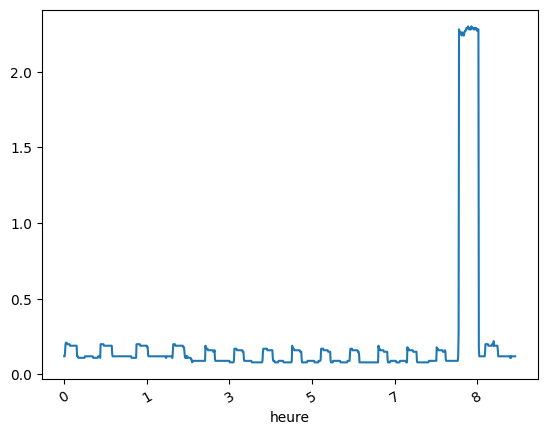

In [375]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df3= conso_day.set_index('heure')
df3.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [376]:
end = time.time()
print(end - start)

24.7198588848114


### grouped by 'heure'

In [377]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1093 entries, 998907 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1093 non-null   int64         
 1   kWh        1093 non-null   float64       
 2   sec        1093 non-null   float64       
 3   Wh         1093 non-null   float64       
 4   cumul(ms)  1093 non-null   int64         
 5   dates      1093 non-null   datetime64[ns]
 6   days       1093 non-null   object        
 7   heure      1093 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 76.9+ KB


In [378]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998907,30748,0.12,30.748,117.080786,26872554580,2025-07-02 00:00:29.510484,02/07/25
998908,30795,0.12,30.795,116.902094,26872585375,2025-07-02 00:01:00.305484,02/07/25
998909,24648,0.15,24.648,146.056475,26872610023,2025-07-02 00:01:24.953484,02/07/25
998910,18153,0.20,18.153,198.314328,26872628176,2025-07-02 00:01:43.106484,02/07/25
998911,17106,0.21,17.106,210.452473,26872645282,2025-07-02 00:02:00.212484,02/07/25
...,...,...,...,...,...,...,...
999995,30909,0.12,30.909,116.470931,26906158646,2025-07-02 09:20:33.576484,02/07/25
999996,30532,0.12,30.532,117.909079,26906189178,2025-07-02 09:21:04.108484,02/07/25
999997,29231,0.12,29.231,123.156922,26906218409,2025-07-02 09:21:33.339484,02/07/25
999998,29478,0.12,29.478,122.124975,26906247887,2025-07-02 09:22:02.817484,02/07/25


In [379]:
# group by hour, df  = data of a chosen day
df_byhour = df3[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [380]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0    138
1    128
2    116
3     97
4    108
5     96
6    105
7     95
8    164
9     46
Name: kWh, dtype: int64

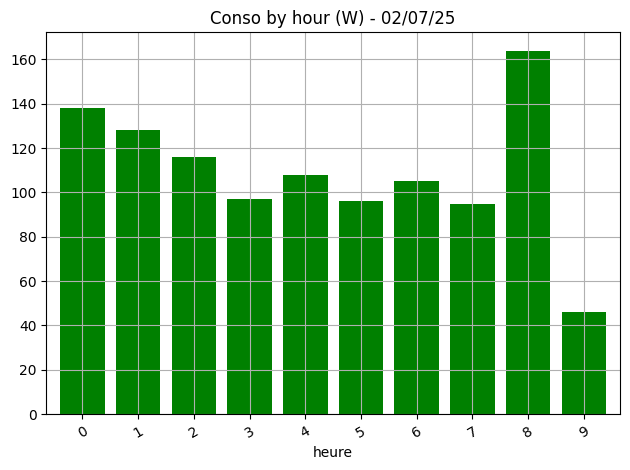

In [381]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [382]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 313 entries, 24/08/24 to 02/07/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     313 non-null    float64
dtypes: float64(1)
memory usage: 4.9+ KB


In [383]:
# give the periods of 1 kwh in a day
period()

2025-07-02 00:00:29.510484	2025-07-02 08:43:24.105484	8h 42m 54s 	1000


In [384]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
    df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


In [385]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [386]:
df_grp.mean()


kWh    3.194888
dtype: float64

In [387]:
df_grp.head()


,kWh
days,
24/08/24,0.097
25/08/24,4.047
26/08/24,3.833
27/08/24,3.953
28/08/24,3.746


In [388]:
df_grp.tail()


,kWh
days,
28/06/25,2.286
29/06/25,2.294
30/06/25,2.770
01/07/25,3.653
02/07/25,1.093


In [389]:
end = time.time()
print(end - start)

25.64096689224243


# plot les 100 derniers jours


In [390]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.02274
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

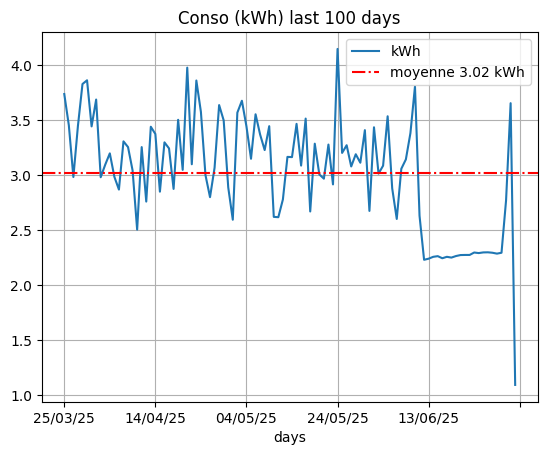

In [391]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label=f'moyenne {np.nanmean(df_100):.2f} kWh')
plt.grid()
plt.legend()
plt.title('Conso (kWh) last 100 days')


In [392]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,1.093
max,4.146


In [393]:
end = time.time()
print(end - start)

26.11972737312317


In [394]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('02/06/25', '27/06/25')

In [395]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    2.6144
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

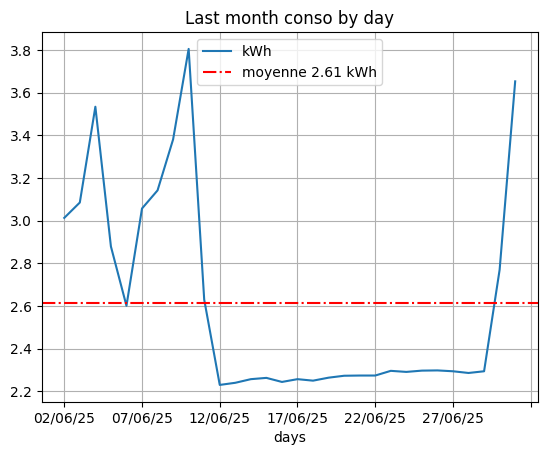

In [396]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label=f'moyenne {np.nanmean(df_grp.iloc[-31:-1]):.2f} kWh')  
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [397]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 10/06/25 3.805
Min : 12/06/25 2.23


# Temps de conso par tranche de 1 kWh

In [398]:
def show_tranches():    # temps de conso par tranches de 1kwh
    tranches = len(df)//1000
    print(tranches+1)
    for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
        if len(df)>(p-1)*1000:
            period(p=p)

show_tranches()


2
2025-07-02 00:00:29.510484	2025-07-02 08:43:24.105484	8h 42m 54s 	1000
2025-07-02 08:43:24.105484	2025-07-02 09:22:32.448484	0h 39m 8s 	93


In [399]:
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


('09:22:48', 1.093, 1093)

In [400]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1093 entries, 998907 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1093 non-null   int64         
 1   kWh        1093 non-null   float64       
 2   sec        1093 non-null   float64       
 3   Wh         1093 non-null   float64       
 4   cumul(ms)  1093 non-null   int64         
 5   dates      1093 non-null   datetime64[ns]
 6   days       1093 non-null   object        
 7   heure      1093 non-null   object        
 8   hours      1093 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 85.4+ KB


In [401]:
conso_hours['heure'], conso_hours['hours']

(998907    0
 998908    0
 998909    0
 998910    0
 998911    0
          ..
 999995    9
 999996    9
 999997    9
 999998    9
 999999    9
 Name: heure, Length: 1093, dtype: object,
 998907    00
 998908    00
 998909    00
 998910    00
 998911    00
           ..
 999995    09
 999996    09
 999997    09
 999998    09
 999999    09
 Name: hours, Length: 1093, dtype: object)

In [402]:
end = time.time()
print(end - start)

27.003145694732666


# select number of days to display


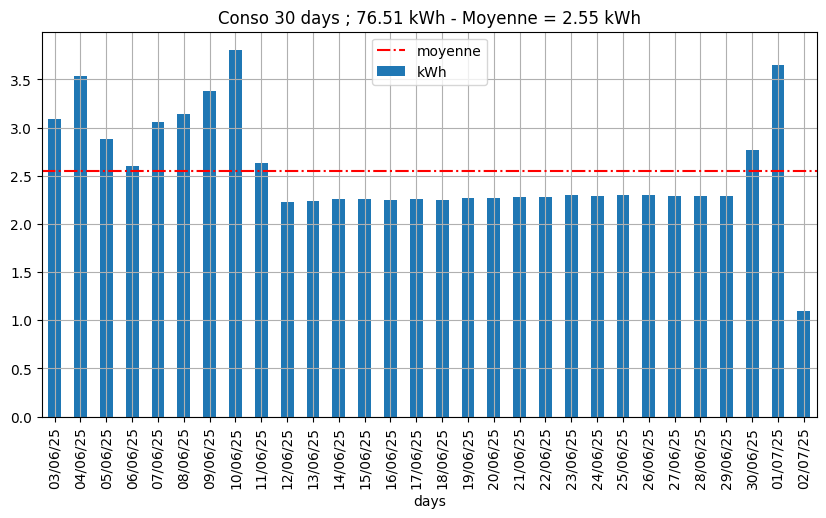

In [403]:
span = 30
conso_mois = round(df_grp.tail(span)['kWh'].sum(),2)

# Plot the figure without labels
moy = round(np.nanmean(df_grp.tail(span)),2)
#conso_mois = sum(df_grp.tail(span)['kWh'])
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight')
 
plt.title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
plt.xticks(rotation=90);


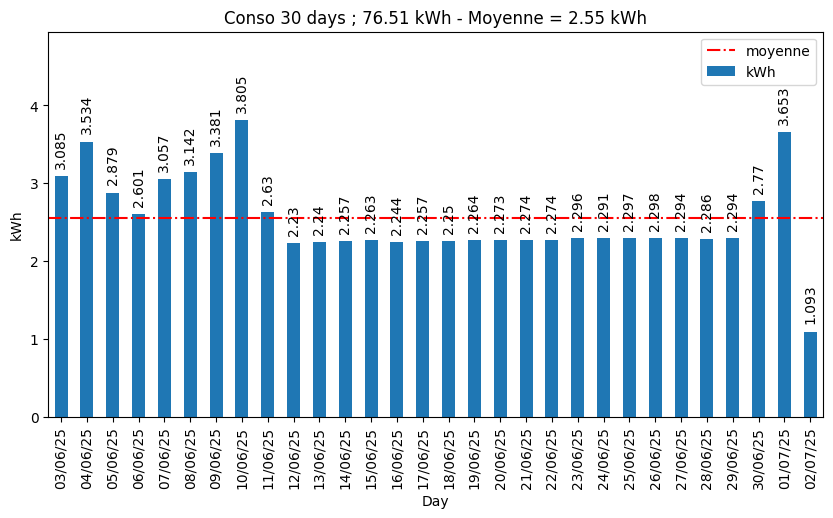

In [404]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
#ax.set_title(f"Conso by {span} days")
ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [405]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
03/06/25    3.085
04/06/25    3.534
05/06/25    2.879
06/06/25    2.601
07/06/25    3.057
08/06/25    3.142
09/06/25    3.381
10/06/25    3.805
11/06/25    2.630
12/06/25    2.230
13/06/25    2.240
14/06/25    2.257
15/06/25    2.263
16/06/25    2.244
17/06/25    2.257
18/06/25    2.250
19/06/25    2.264
20/06/25    2.273
21/06/25    2.274
22/06/25    2.274
23/06/25    2.296
24/06/25    2.291
25/06/25    2.297
26/06/25    2.298
27/06/25    2.294
28/06/25    2.286
29/06/25    2.294
30/06/25    2.770
01/07/25    3.653
02/07/25    1.093
Name: kWh, dtype: float64

In [406]:
x_labels=df_grp.tail(span).index
x_labels

Index(['03/06/25', '04/06/25', '05/06/25', '06/06/25', '07/06/25', '08/06/25',
       '09/06/25', '10/06/25', '11/06/25', '12/06/25', '13/06/25', '14/06/25',
       '15/06/25', '16/06/25', '17/06/25', '18/06/25', '19/06/25', '20/06/25',
       '21/06/25', '22/06/25', '23/06/25', '24/06/25', '25/06/25', '26/06/25',
       '27/06/25', '28/06/25', '29/06/25', '30/06/25', '01/07/25', '02/07/25'],
      dtype='object', name='days')

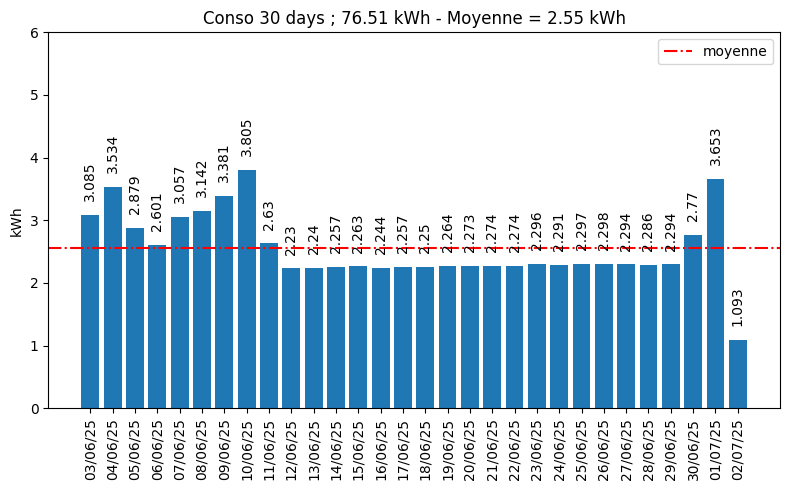

In [407]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
#ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
ax.set(ylabel='kWh', title=f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh', ylim=(0, 6))
plt.xticks(rotation=90);


In [408]:
end = time.time()
print(end - start)

30.12488603591919


In [409]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

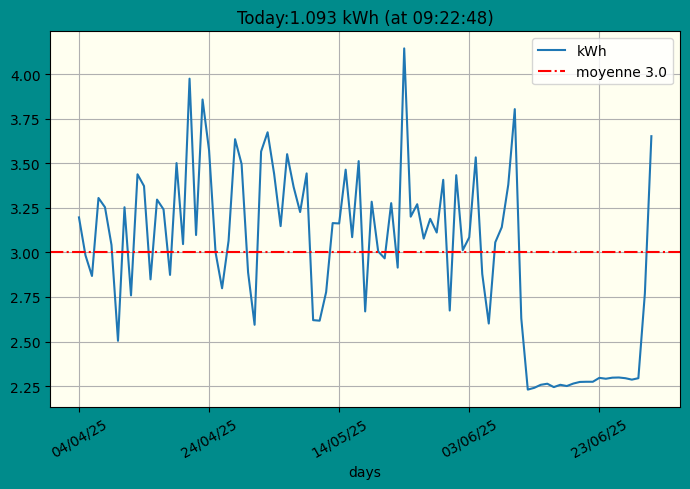

In [410]:
# 3 last months
scan = 90
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

moy = round(np.nanmean(df_grp.iloc[-scan:-1]),2)
df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(f'Today:{last} kWh (at {here})')
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

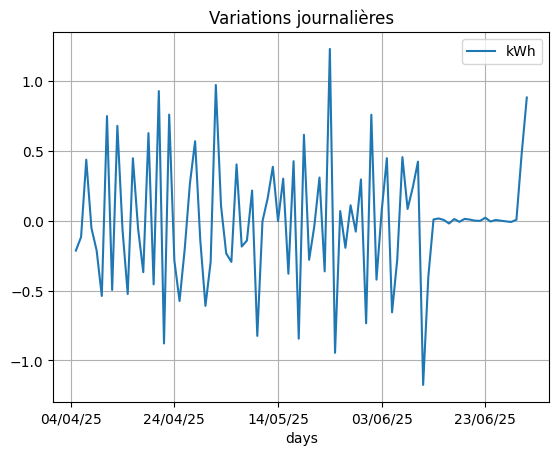

In [411]:
# variations journalières sur 60 jours
df_grp.iloc[-scan:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [412]:
end = time.time()
print(end - start)

31.000702381134033


# Data from 21/08/23

In [413]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,24400,0.15,24.400,147.540984,24400,2024-08-24 23:24:59.330484,24/08/24,23,2024-08,24
1,24252,0.15,24.252,148.441366,48652,2024-08-24 23:25:23.582484,24/08/24,23,2024-08,24
2,24406,0.15,24.406,147.504712,73058,2024-08-24 23:25:47.988484,24/08/24,23,2024-08,24
3,24268,0.15,24.268,148.343498,97326,2024-08-24 23:26:12.256484,24/08/24,23,2024-08,24
4,24482,0.15,24.482,147.046810,121808,2024-08-24 23:26:36.738484,24/08/24,23,2024-08,24
...,...,...,...,...,...,...,...,...,...,...
999995,30909,0.12,30.909,116.470931,26906158646,2025-07-02 09:20:33.576484,02/07/25,09,2025-07,02
999996,30532,0.12,30.532,117.909079,26906189178,2025-07-02 09:21:04.108484,02/07/25,09,2025-07,02
999997,29231,0.12,29.231,123.156922,26906218409,2025-07-02 09:21:33.339484,02/07/25,09,2025-07,02
999998,29478,0.12,29.478,122.124975,26906247887,2025-07-02 09:22:02.817484,02/07/25,09,2025-07,02


In [414]:
end = time.time()
print(end - start)

65.23750805854797


In [415]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07'])

# define month to show

Text(0.5, 1.0, 'Conso by day (W) (2025-04)')

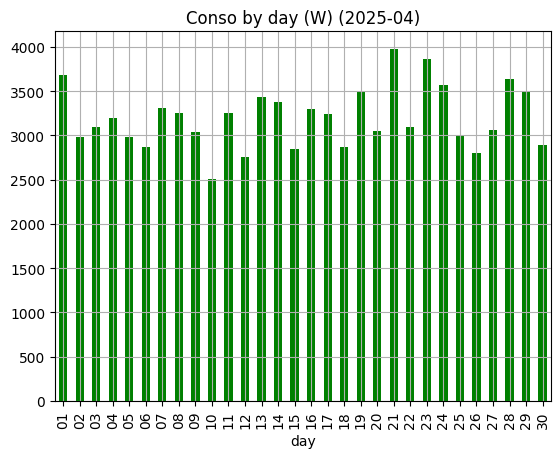

In [416]:
m = '2025-04'
month=conso_grouped_by_month.get_group(m)
conso_grouped_by_month_day = month.groupby(['day'], sort=False)
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)
plt.title(f'Conso by day (W) ({m})')

In [417]:
c=conso_grouped_by_month_day['hours'].count()
c.mean()


np.float64(3198.1666666666665)

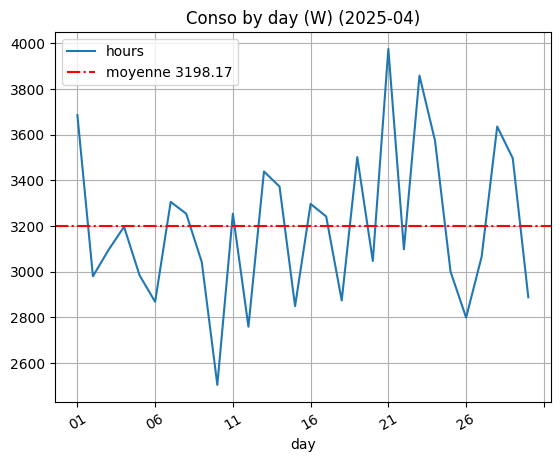

In [418]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
moy = round(c.mean(),2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (W) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);


In [419]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

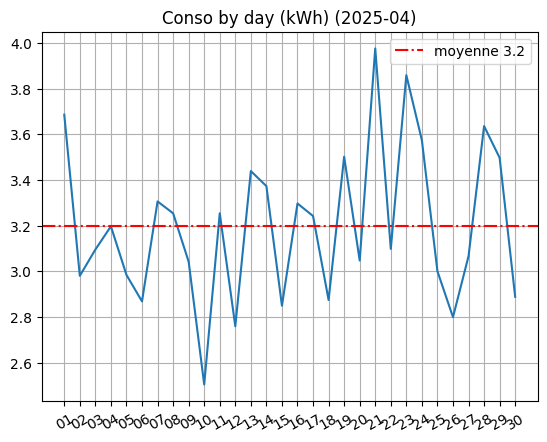

In [420]:
plt.plot(conso_grouped_by_month_day['kWh'].count()/1000)
plt.grid()
moy = round(c.mean()/1000,2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (kWh) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);

In [421]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [422]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [423]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-08,27022,27022,27022
2024-09,69918,69918,69918
2024-10,73358,73358,73358
2024-11,108178,108178,108178
2024-12,113984,113984,113984
2025-01,113845,113845,113845
2025-02,104376,104376,104376
2025-03,111793,111793,111793
2025-04,95945,95945,95945


In [424]:
# example groupby with apply
df2 = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df2.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [425]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [426]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
24/08/24,97
25/08/24,4047
26/08/24,3833
27/08/24,3953
28/08/24,3746
...,...
28/06/25,2286
29/06/25,2294
30/06/25,2770


In [427]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,24400,0.15,24.400,147.540984,24400,2024-08-24 23:24:59.330484,24/08/24,23,2024-08,24
1,24252,0.15,24.252,148.441366,48652,2024-08-24 23:25:23.582484,24/08/24,23,2024-08,24
2,24406,0.15,24.406,147.504712,73058,2024-08-24 23:25:47.988484,24/08/24,23,2024-08,24
3,24268,0.15,24.268,148.343498,97326,2024-08-24 23:26:12.256484,24/08/24,23,2024-08,24
4,24482,0.15,24.482,147.046810,121808,2024-08-24 23:26:36.738484,24/08/24,23,2024-08,24
...,...,...,...,...,...,...,...,...,...,...
999995,30909,0.12,30.909,116.470931,26906158646,2025-07-02 09:20:33.576484,02/07/25,09,2025-07,02
999996,30532,0.12,30.532,117.909079,26906189178,2025-07-02 09:21:04.108484,02/07/25,09,2025-07,02
999997,29231,0.12,29.231,123.156922,26906218409,2025-07-02 09:21:33.339484,02/07/25,09,2025-07,02
999998,29478,0.12,29.478,122.124975,26906247887,2025-07-02 09:22:02.817484,02/07/25,09,2025-07,02


In [428]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
24/08/24 23    0       24/08/24    23  0.15
               1       24/08/24    23  0.15
               2       24/08/24    23  0.15
               3       24/08/24    23  0.15
               4       24/08/24    23  0.15
...                         ...   ...   ...
02/07/25 09    999995  02/07/25    09  0.12
               999996  02/07/25    09  0.12
               999997  02/07/25    09  0.12
               999998  02/07/25    09  0.12
               999999  02/07/25    09  0.12

[1000000 rows x 3 columns]

In [429]:
groupallbyday.indices.keys()

dict_keys(['24/08/24', '25/08/24', '26/08/24', '27/08/24', '28/08/24', '29/08/24', '30/08/24', '31/08/24', '01/09/24', '02/09/24', '03/09/24', '04/09/24', '05/09/24', '06/09/24', '07/09/24', '08/09/24', '09/09/24', '10/09/24', '11/09/24', '12/09/24', '13/09/24', '14/09/24', '15/09/24', '16/09/24', '17/09/24', '18/09/24', '19/09/24', '20/09/24', '21/09/24', '22/09/24', '23/09/24', '24/09/24', '25/09/24', '26/09/24', '27/09/24', '28/09/24', '29/09/24', '30/09/24', '01/10/24', '02/10/24', '03/10/24', '04/10/24', '05/10/24', '06/10/24', '07/10/24', '08/10/24', '09/10/24', '10/10/24', '11/10/24', '12/10/24', '13/10/24', '14/10/24', '15/10/24', '16/10/24', '17/10/24', '18/10/24', '19/10/24', '20/10/24', '21/10/24', '22/10/24', '23/10/24', '24/10/24', '25/10/24', '26/10/24', '27/10/24', '28/10/24', '29/10/24', '30/10/24', '31/10/24', '01/11/24', '02/11/24', '03/11/24', '04/11/24', '05/11/24', '06/11/24', '07/11/24', '08/11/24', '09/11/24', '10/11/24', '11/11/24', '12/11/24', '13/11/24', '14/1

In [430]:
groupallbydayhours.indices.keys()

dict_keys([('24/08/24', '23'), ('25/08/24', '23'), ('25/08/24', '00'), ('25/08/24', '01'), ('25/08/24', '02'), ('25/08/24', '03'), ('25/08/24', '04'), ('25/08/24', '05'), ('25/08/24', '06'), ('25/08/24', '07'), ('25/08/24', '08'), ('25/08/24', '09'), ('25/08/24', '10'), ('25/08/24', '11'), ('25/08/24', '12'), ('25/08/24', '13'), ('25/08/24', '14'), ('25/08/24', '15'), ('25/08/24', '16'), ('25/08/24', '17'), ('25/08/24', '18'), ('25/08/24', '19'), ('25/08/24', '20'), ('25/08/24', '21'), ('25/08/24', '22'), ('26/08/24', '23'), ('26/08/24', '00'), ('26/08/24', '01'), ('26/08/24', '02'), ('26/08/24', '03'), ('26/08/24', '04'), ('26/08/24', '05'), ('26/08/24', '06'), ('26/08/24', '07'), ('26/08/24', '08'), ('26/08/24', '09'), ('26/08/24', '10'), ('26/08/24', '11'), ('26/08/24', '12'), ('26/08/24', '13'), ('26/08/24', '14'), ('26/08/24', '15'), ('26/08/24', '16'), ('26/08/24', '17'), ('26/08/24', '18'), ('26/08/24', '19'), ('26/08/24', '20'), ('26/08/24', '21'), ('26/08/24', '22'), ('27/08/2

In [431]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
24/08/24,97,97
25/08/24,4047,4047
26/08/24,3833,3833
27/08/24,3953,3953
28/08/24,3746,3746
...,...,...
28/06/25,2286,2286
29/06/25,2294,2294
30/06/25,2770,2770


In [432]:
grp_by_day['kWh'].cumsum()

days
24/08/24         97
25/08/24       4144
26/08/24       7977
27/08/24      11930
28/08/24      15676
             ...   
28/06/25     990190
29/06/25     992484
30/06/25     995254
01/07/25     998907
02/07/25    1000000
Name: kWh, Length: 313, dtype: int64

In [433]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
24/08/24 23      97
25/08/24 00     152
         01     154
         02     154
         03     148
...             ...
02/07/25 05      96
         06     105
         07      95
         08     164
         09      46

[7475 rows x 1 columns]

In [434]:
grp_by_dayhours['kWh'].cumsum()

days      hours
24/08/24  23            97
25/08/24  00           249
          01           403
          02           557
          03           705
                    ...   
02/07/25  05        999590
          06        999695
          07        999790
          08        999954
          09       1000000
Name: kWh, Length: 7475, dtype: int64

In [435]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
24/08/24 23      97      97    NaN
25/08/24 00     152     152    NaN
         01     154     306    2.0
         02     154     460    0.0
         03     148     608   -6.0
...             ...     ...    ...
02/07/25 05      96     683  -12.0
         06     105     788    9.0
         07      95     883  -10.0
         08     164    1047   69.0
         09      46    1093 -118.0

[7475 rows x 3 columns]

In [436]:
today, grp_by_dayhours.loc[today]

('02/07/25',
        kWh  cumsum   diff
 hours                    
 00     138     138    NaN
 01     128     266  -10.0
 02     116     382  -12.0
 03      97     479  -19.0
 04     108     587   11.0
 05      96     683  -12.0
 06     105     788    9.0
 07      95     883  -10.0
 08     164    1047   69.0
 09      46    1093 -118.0)

Text(0.5, 1.0, 'Cumul journalier')

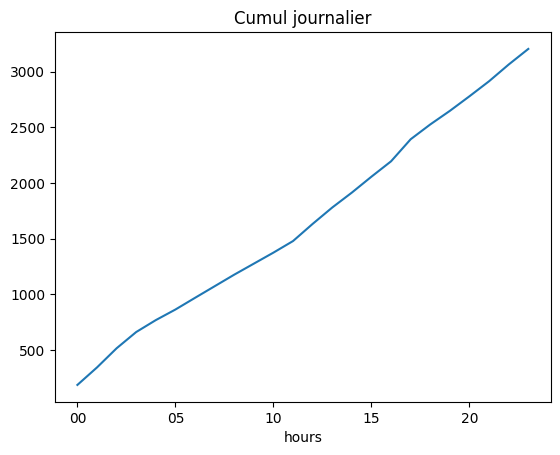

In [437]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

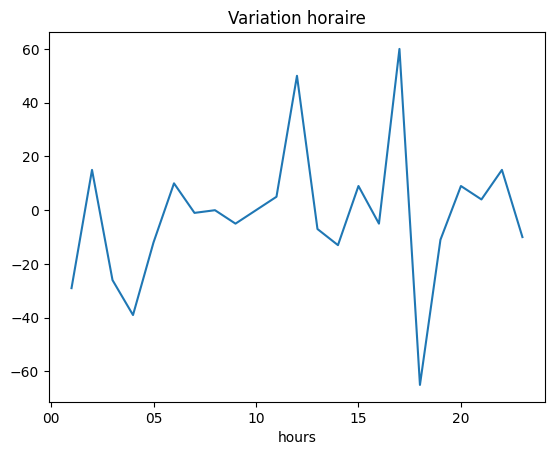

In [438]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [439]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

313

In [440]:
df_grp.tail(n)['kWh'].describe()


count    313.000000
mean       3.194888
std        0.765170
min        0.097000
25%        2.874000
50%        3.374000
75%        3.690000
max        4.753000
Name: kWh, dtype: float64

In [441]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [442]:
n, np.nanmean(df_grp.tail(n))

(313, np.float64(3.194888178913738))

Text(0.5, 1.0, '313 days')

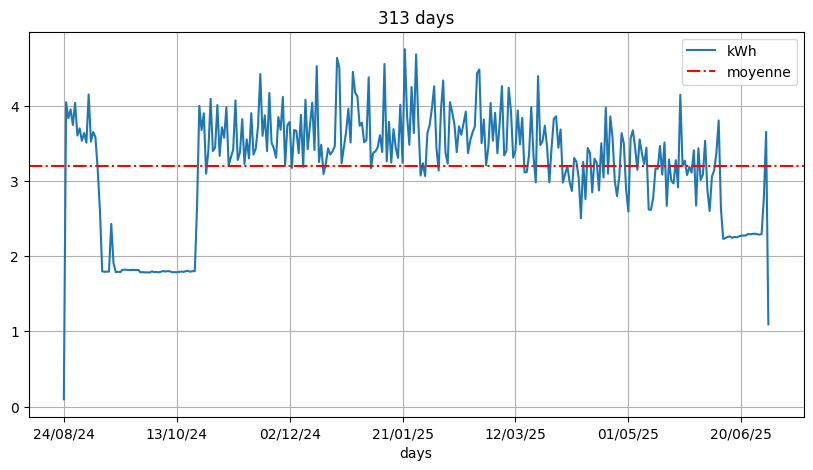

In [443]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

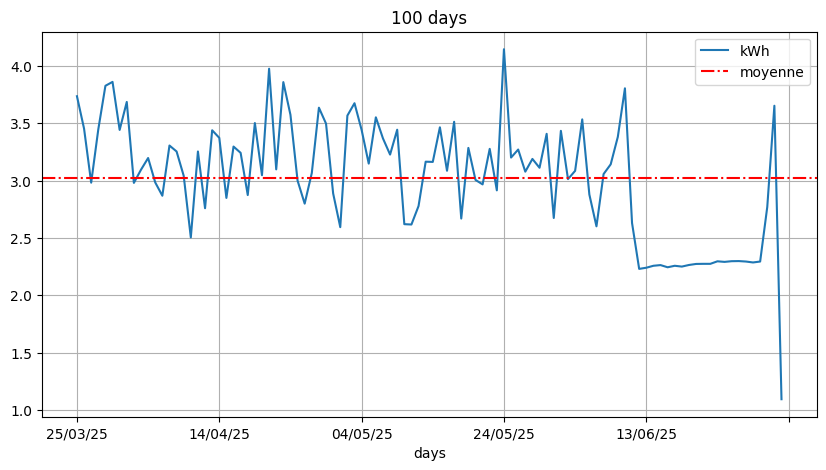

In [444]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

In [445]:
np.nanmean(df_grp.tail(span))

np.float64(3.0227399999999993)

In [446]:
df_grp['kWh']

days
24/08/24    0.097
25/08/24    4.047
26/08/24    3.833
27/08/24    3.953
28/08/24    3.746
            ...  
28/06/25    2.286
29/06/25    2.294
30/06/25    2.770
01/07/25    3.653
02/07/25    1.093
Name: kWh, Length: 313, dtype: float64

In [447]:
df_grp.describe()

,kWh
count,313.000000
mean,3.194888
std,0.765170
min,0.097000
25%,2.874000
50%,3.374000
75%,3.690000
max,4.753000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

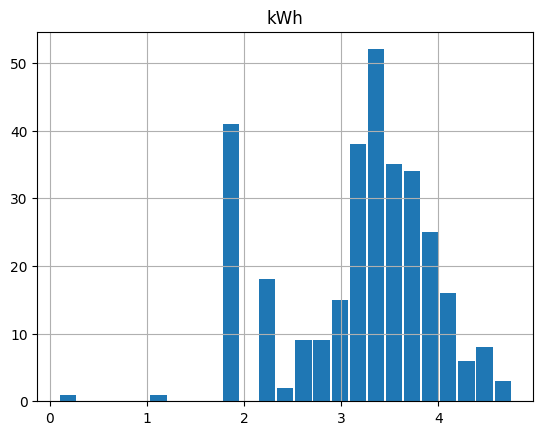

In [448]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [449]:
df_grp.tail(span)['kWh']

days
25/03/25    3.736
26/03/25    3.453
27/03/25    2.982
28/03/25    3.447
29/03/25    3.827
            ...  
28/06/25    2.286
29/06/25    2.294
30/06/25    2.770
01/07/25    3.653
02/07/25    1.093
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [450]:
day

'02/07/25'

In [451]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,138,138,NaN
01,128,266,-10.0
02,116,382,-12.0
03,97,479,-19.0
04,108,587,11.0
05,96,683,-12.0
06,105,788,9.0
07,95,883,-10.0
08,164,1047,69.0


In [452]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


10

In [453]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 11)

In [454]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [455]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [456]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
Name: days, dtype: float64

In [457]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [458]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 00 to 09
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     10 non-null     int64  
 1   cumsum  10 non-null     int64  
 2   diff    9 non-null      float64
 3   days    10 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 400.0+ bytes


In [459]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
Name: days, dtype: float64

In [460]:
day

'02/07/25'

In [461]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,138,138,NaN,1.0
01,128,266,-10.0,2.0
02,116,382,-12.0,3.0
03,97,479,-19.0,4.0
04,108,587,11.0,5.0
05,96,683,-12.0,6.0
06,105,788,9.0,7.0
07,95,883,-10.0,8.0
08,164,1047,69.0,9.0


In [462]:
kwh = grp_by_dayhours.loc[day][['kWh']]/1000
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_6040\2885532441.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.float64(1.093)

In [463]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
24/08/24 23      97      97    NaN   NaN
25/08/24 00     152     152    NaN   NaN
         01     154     306    2.0   NaN
         02     154     460    0.0   NaN
         03     148     608   -6.0   NaN
...             ...     ...    ...   ...
02/07/25 05      96     683  -12.0   6.0
         06     105     788    9.0   7.0
         07      95     883  -10.0   8.0
         08     164    1047   69.0   9.0
         09      46    1093 -118.0  10.0

[7475 rows x 4 columns]

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '02/07/25: kWh    1.093\ndtype: float64')

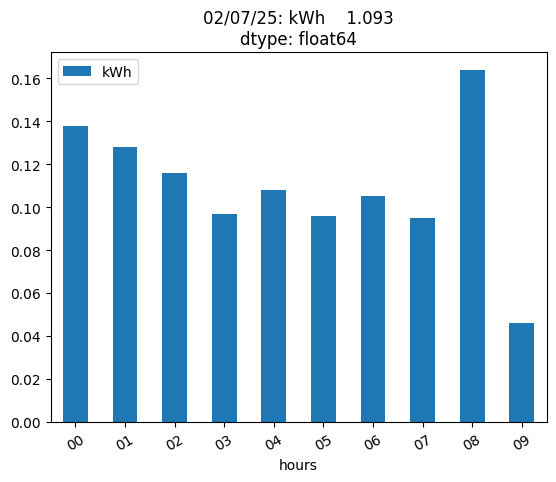

In [464]:
kwh.plot.bar(label='watt')
plt.legend()
plt.xticks(rotation=30)
plt.title(f'{day}: {np.sum(kwh)}')

In [465]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09'], dtype='object', name='hours')

# Conso du jour


In [466]:
grp_by_dayhours.count()

kWh       7475
cumsum    7475
diff      7162
days        10
dtype: int64

'22/01/25'

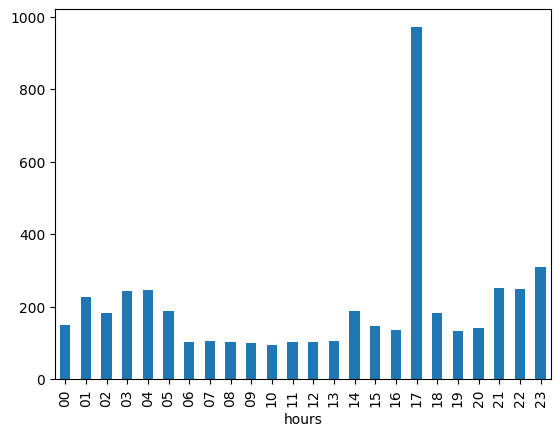

In [467]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [468]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

Total= 302.274 , Moyenne= 3.0227399999999993


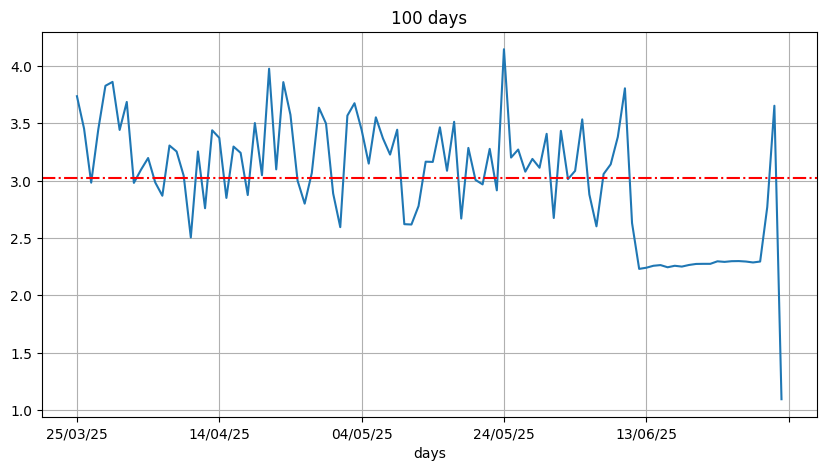

In [469]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [470]:
from datetime import datetime

# Get the current time
current_time = datetime.now()

# Convert the time to minutes in a day
minutes_in_day = current_time.hour * 60 + current_time.minute
print(f"Current time: {current_time.strftime('%H:%M:%S')}, Minutes in day: {minutes_in_day}")

Current time: 09:23:45, Minutes in day: 563


In [471]:
def convert_to_min_sec(seconds):
    """
    Convert a float value in seconds to minutes and seconds.
    """
    minutes, sec = divmod(seconds, 60)
    return f'{int(minutes)}:{round(sec, 2)}'


In [472]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(convert_to_min_sec(end - start))

1:18.87


In [473]:
end - start

78.87131142616272

In [474]:
#df = conso_day
show_tranches()

2
2025-07-02 00:00:29.510484	2025-07-02 08:43:24.105484	8h 42m 54s 	1000
2025-07-02 08:43:24.105484	2025-07-02 09:22:32.448484	0h 39m 8s 	93


In [475]:
df_grp.tail(7)['kWh']

days
26/06/25    2.298
27/06/25    2.294
28/06/25    2.286
29/06/25    2.294
30/06/25    2.770
01/07/25    3.653
02/07/25    1.093
Name: kWh, dtype: float64

<Axes: xlabel='days'>

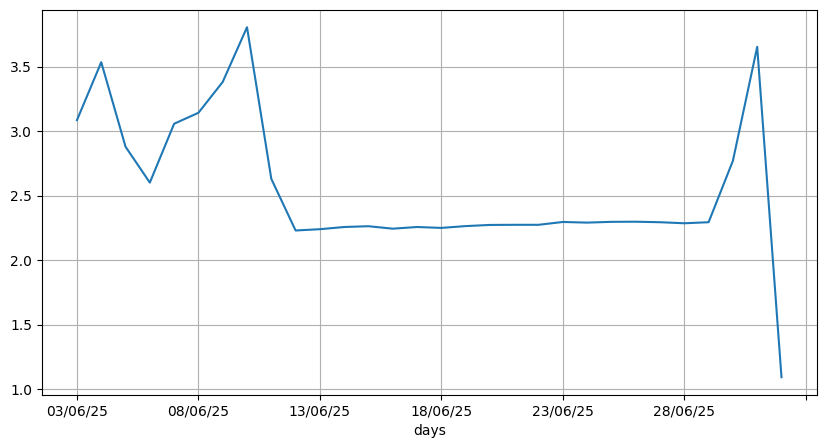

In [476]:
df_grp.tail(30)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)

# Today

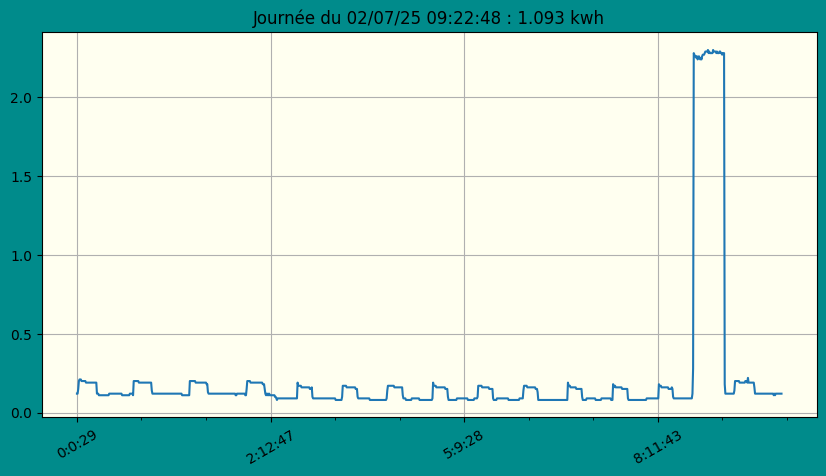

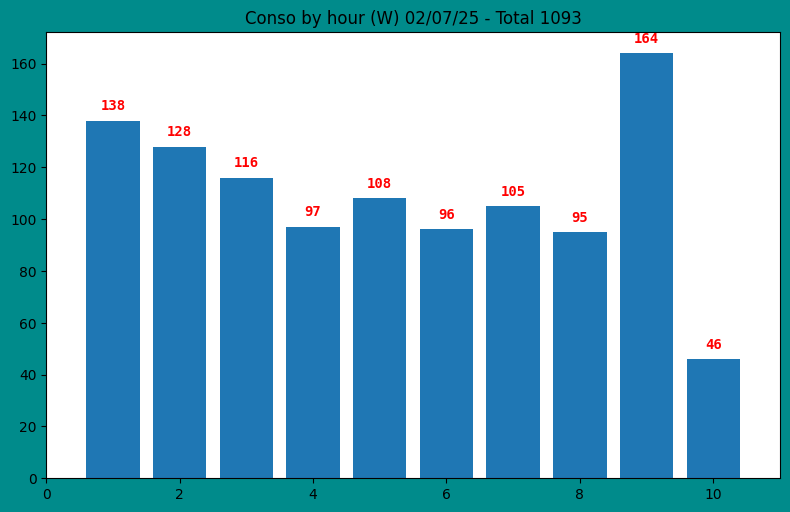

In [477]:
show(today,bgcolor='ivory')
conso_by_hour(today)

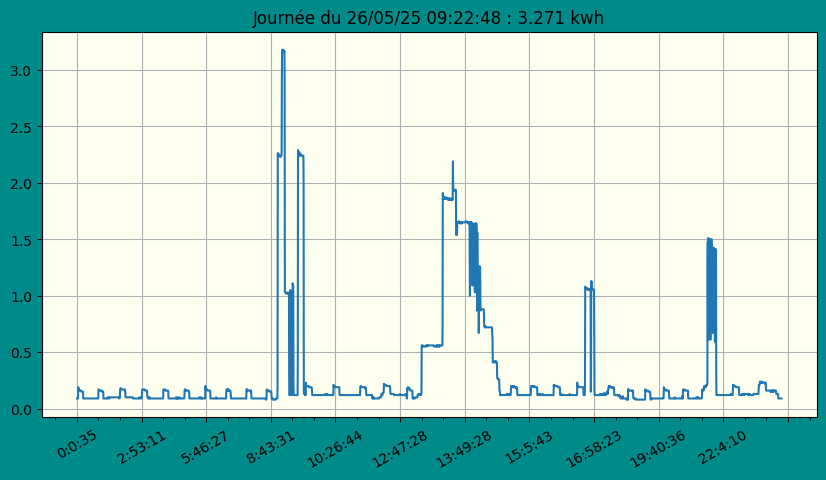

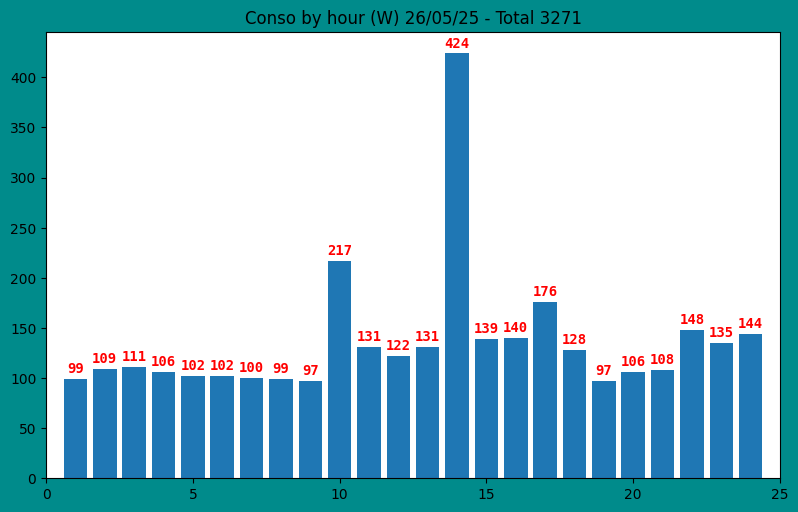

In [478]:
# 21/04/25 cuisine midi et télé le soir 4.115 kWh
day = '26/05/25' 
day, show(day,bgcolor='ivory')
conso_by_hour(day)

22/01/25


(None, 4753)

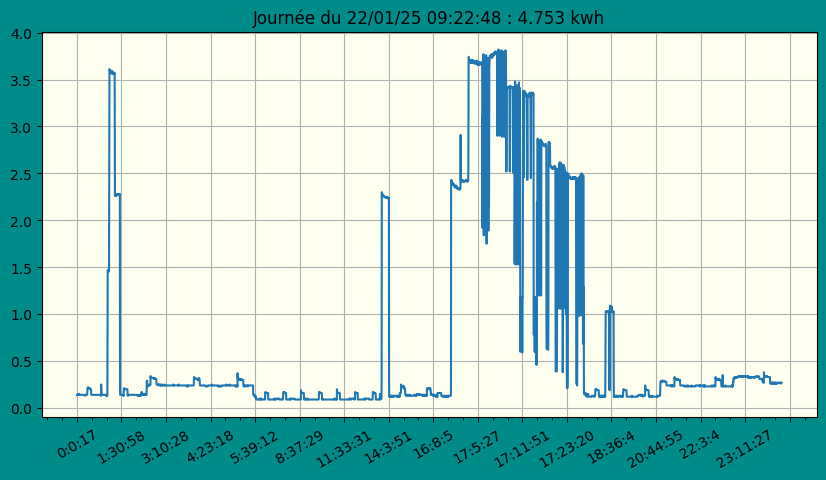

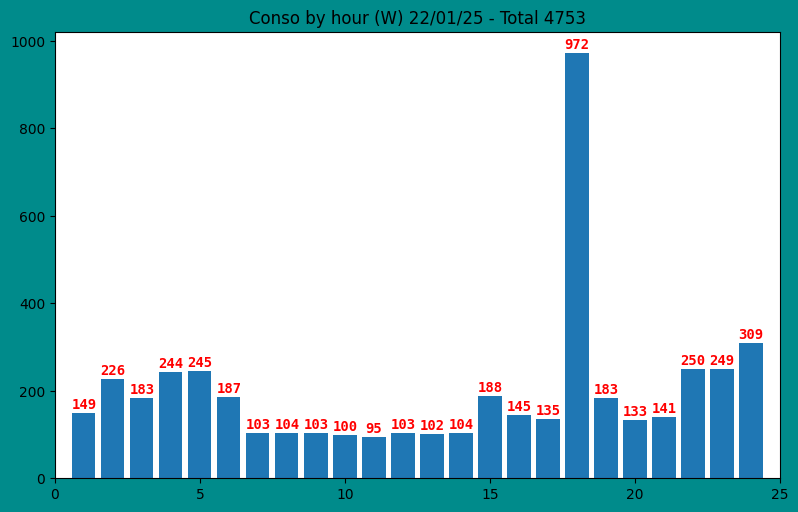

In [479]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

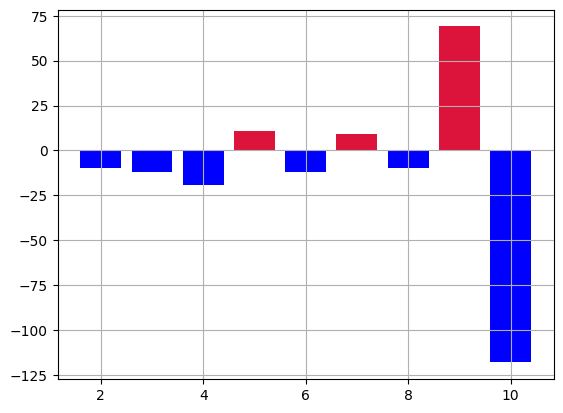

In [480]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

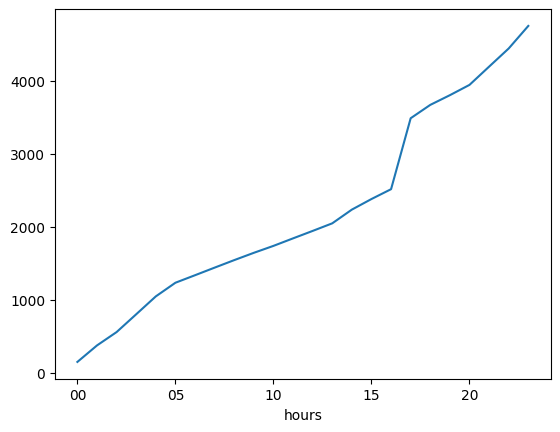

In [481]:
data.cumsum().plot()


<Axes: xlabel='hours'>

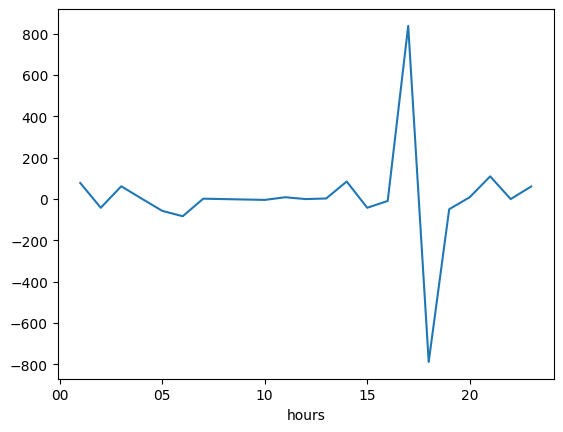

In [482]:
# evolution par heure
data.diff().plot()

In [483]:
data.diff().describe()

count     23.000000
mean       6.956522
std      249.640920
min     -789.000000
25%      -26.500000
50%       -1.000000
75%       34.000000
max      837.000000
Name: kWh, dtype: float64

<Axes: >

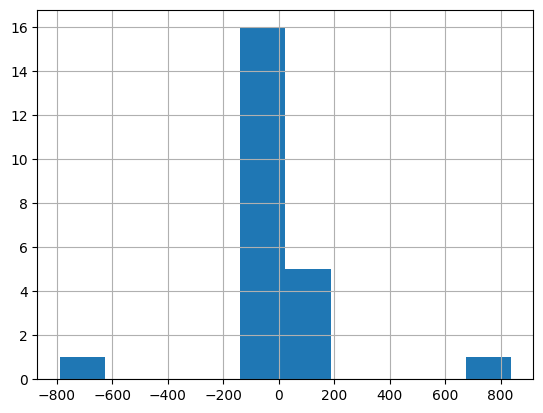

In [484]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [485]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'eur_vnd_change_data.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'sun_moon_paris_20250603.png',
 'isp_simulation_falcon9.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'sun_moon_azimuth_paris_2025-06-06.png',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'sun_moon_paris_20250605.png',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'de421.bsp'

# list store files csv


In [486]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('22/01/25', None)

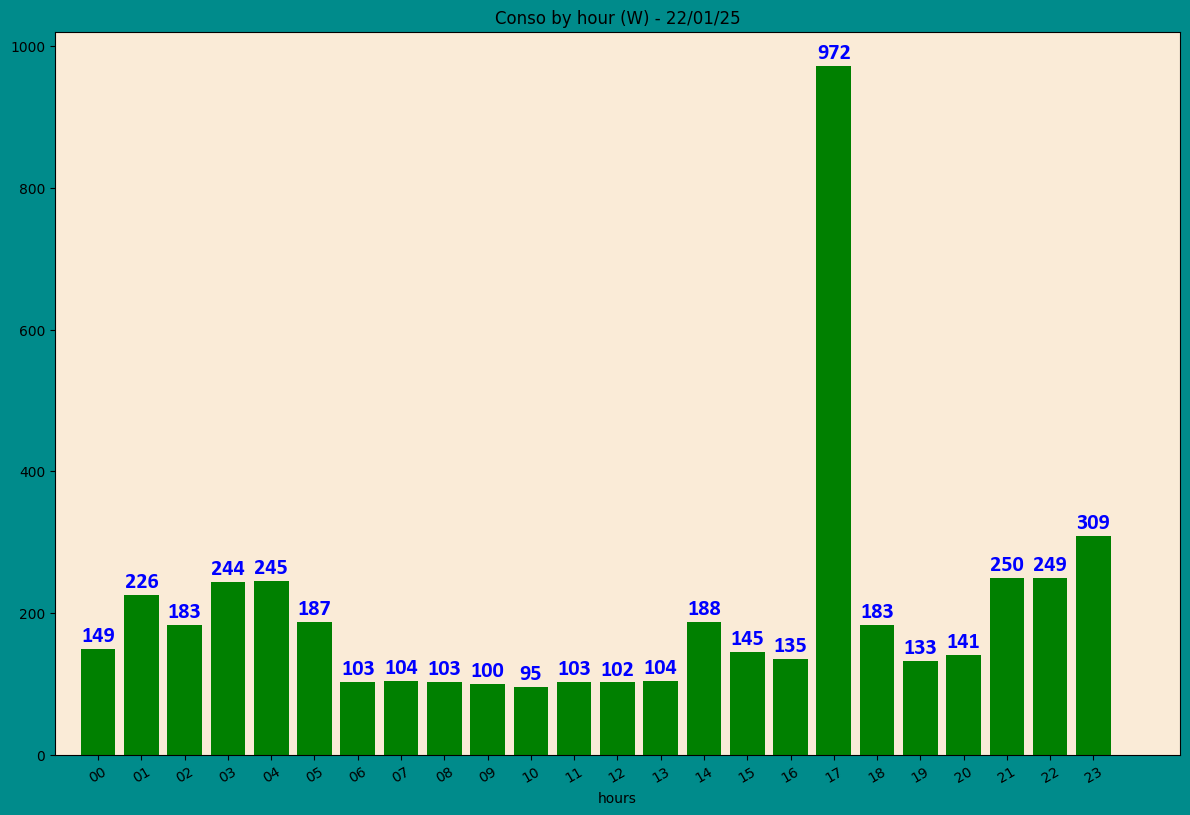

In [487]:
day,conso_byhour(day)

In [488]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


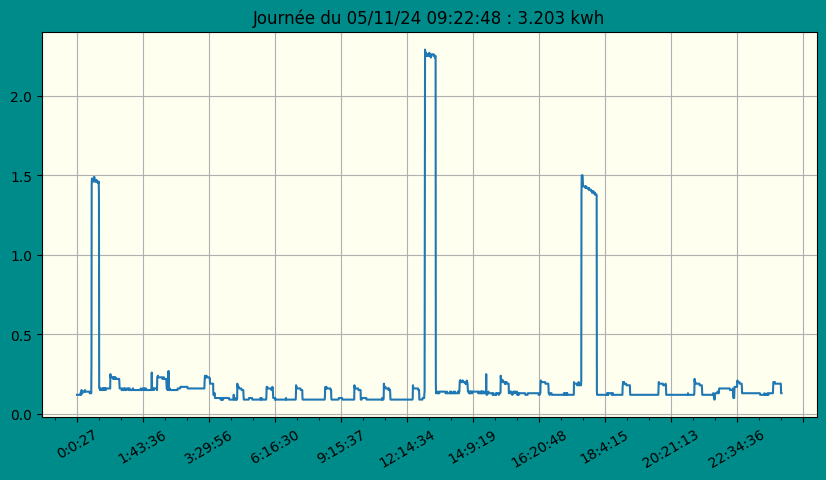

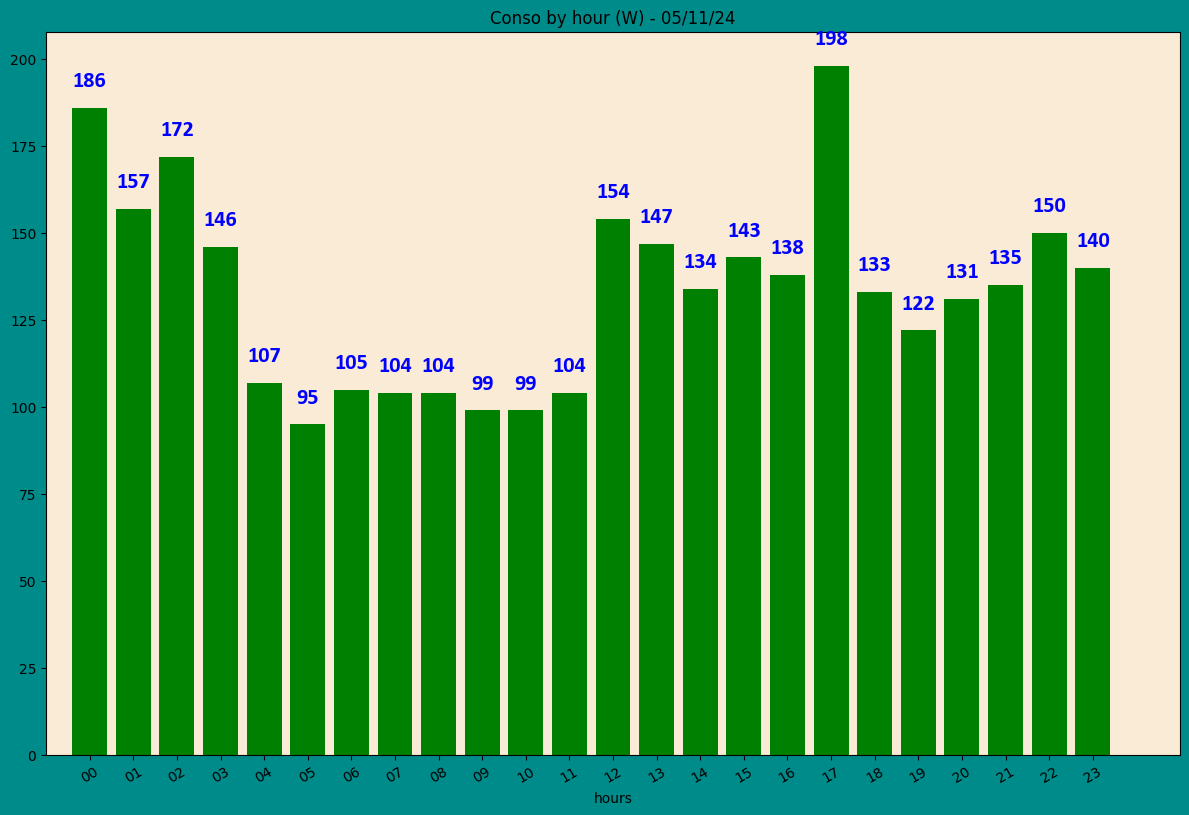

In [489]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [490]:
month

,day,hours,months,kWh
722474,01,00,2025-04,0.21
722475,01,00,2025-04,0.21
722476,01,00,2025-04,0.21
722477,01,00,2025-04,0.21
722478,01,00,2025-04,0.21
...,...,...,...,...
818414,30,23,2025-04,0.09
818415,30,23,2025-04,0.09
818416,30,23,2025-04,0.09
818417,30,23,2025-04,0.09


In [491]:
month.describe()


,kWh
count,95945.000000
mean,0.310170
std,0.547543
min,0.080000
25%,0.090000
50%,0.120000
75%,0.180000
max,3.790000


<Axes: >

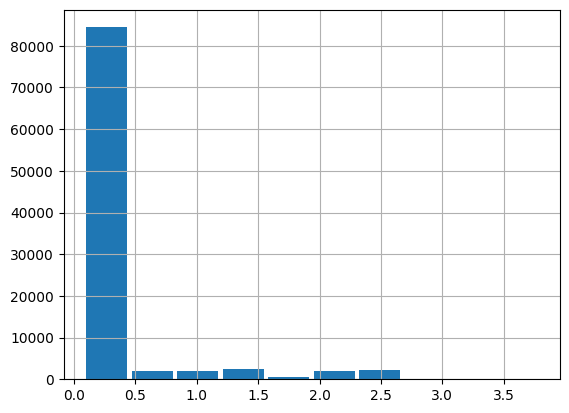

In [492]:
# bins of conso scale by hour
month['kWh'].hist(bins=10, density=False, histtype='bar',rwidth=0.9, align='mid')

<Axes: >

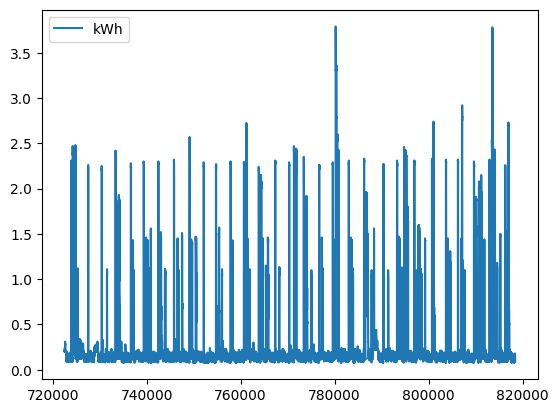

In [493]:
month.plot()

In [494]:
# index with max conso in this month
month.idxmax().kWh

np.int64(780220)

In [495]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       815531
hours     725977
months    722474
kWh       780220
dtype: int64

In [496]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [497]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
24/08/24 23      97      97    NaN   NaN
25/08/24 00     152     152    NaN   NaN
         01     154     306    2.0   NaN
         02     154     460    0.0   NaN
         03     148     608   -6.0   NaN
...             ...     ...    ...   ...
02/07/25 05      96     683  -12.0   6.0
         06     105     788    9.0   7.0
         07      95     883  -10.0   8.0
         08     164    1047   69.0   9.0
         09      46    1093 -118.0  10.0

[7475 rows x 4 columns]

In [498]:
month

,day,hours,months,kWh
722474,01,00,2025-04,0.21
722475,01,00,2025-04,0.21
722476,01,00,2025-04,0.21
722477,01,00,2025-04,0.21
722478,01,00,2025-04,0.21
...,...,...,...,...
818414,30,23,2025-04,0.09
818415,30,23,2025-04,0.09
818416,30,23,2025-04,0.09
818417,30,23,2025-04,0.09


In [499]:
month.idxmax()


day       815531
hours     725977
months    722474
kWh       780220
dtype: int64

In [500]:
month.loc[month.idxmax().kWh]


day            19
hours          14
months    2025-04
kWh          3.79
Name: 780220, dtype: object

In [501]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       167
          01       179
          02       151
          03       114
          04       106
          05       105
          06       111
          07       111
          08       101
          09       107
          10       110
          11       109
          12       178
          13       140
          14       149
          15       146
          16       195
          17       141
          18       195
          19       158
          20       149
          21       143
          22       160
          23       226
Name: kWh, dtype: int64

In [502]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'23'

<Axes: xlabel='days,hours'>

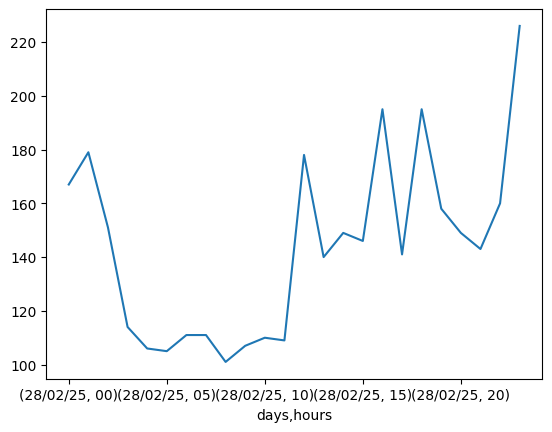

In [503]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [504]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [505]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [506]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [507]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB